In [87]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [88]:
normalizer = StandardScaler()
data = pd.read_csv('../Datasets/Sensor Readings/weight.csv')

In [89]:
def normalize(data, test):
    xTrain = normalizer.fit_transform(data.values.reshape(-1,1))
    xTest = normalizer.transform(test.values.reshape(-1,1))
    return xTrain, xTest


In [90]:
def build(n1= 16, n2= 8):
    
    encoder = Sequential([
    Input(shape=(1,)), 
    Dense(n1, activation='relu'),
    Dense(n2, activation='relu')
])

    
    decoder = Sequential([
    Input(shape=(n2,)),
    Dense(n1, activation='relu'),  
    Dense(1, activation='linear')                    
])
    
    model = Sequential([encoder, decoder])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.summary()
    return model

In [91]:
def train(model, data, epochs=100):
    model.fit(data, data, epochs=epochs, shuffle=True, batch_size=32, validation_split=0.2, verbose=1)
    return model

In [92]:
def test(model, data, threshold=85):
    errors = []
    predictions = model.predict(data)
    for i in range(len(data)):
        mse = mean_squared_error(data[i], predictions[i])
        errors.append(mse)
        
    threshold =  np.percentile(errors, threshold)  
    for i in range(len(data)):
        if errors[i] >= threshold:
            print(f"Anomaly Detected for weight: {data[i][0]:.4f} with Mean Squared Error (MSE): {errors[i]:.4f}")
      
    return predictions, errors, threshold

In [93]:
def plotErrors(predictions, errors, threshold):
    normal = [i for i in range(len(errors)) if errors[i] < threshold]
    anomalies = [i for i in range(len(errors)) if errors[i] >= threshold]
    plt.figure(figsize=(10, 6))
    plt.scatter(normal, [errors[i] for i in normal], color='g', label='Normal', alpha=0.6)
    
    plt.scatter(anomalies, [errors[i] for i in anomalies], color='r', label='Anomalous', alpha=0.6)    
    plt.axhline(threshold, color='black', linestyle='--', label=f'Threshold ({threshold:.2f})')
    
    plt.xlabel("Data Index")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Anomaly Detection - MSE Errors")
    plt.legend(loc='upper right')
    
    plt.show()

In [94]:
def plotReconstructedData(reconstructed, minNormalValue, maxNormalValue):
    norm = reconstructed[reconstructed >= minNormalValue]
    normal = np.concatenate((norm, reconstructed[reconstructed <= maxNormalValue]))
    aanamoly = reconstructed[reconstructed < minNormalValue]
    anomalous = np.concatenate((anamoly, reconstructed[reconstructed > maxNormalValue]))

    plt.scatter(np.arange(len(normal)), normal, color='g', label='Normal Data')
    plt.scatter(np.arange(len(anomalous)), anomalous, color='r', label='Anomalous Data')

    plt.xlabel("Index")
    plt.ylabel("Reconstructed Value")
    plt.title("Reconstructed Data with Normal and Anomalous Values")
    plt.legend()

    plt.show()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_33 (Sequential)      │ (None, 8)              │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_34 (Sequential)      │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
13103/13103 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.0338 - val_loss: 4.9762e-05
Epoch 2/5
13103/13103 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 2.4897e-05 - val_loss: 6.7341e-06
Epoch 3/5
13103/13103 ━━━━━━━━━━━━━━━━━━━━ 13s 989us/step - loss: 3.5330e-05 - val_loss: 1.2335e-05
Epoch 4/5
13103/13103 ━━━━━━━━━━━━━━━━━━━━ 13s 997us/step - loss: 1.8451e-05 - val_loss: 3.5419e-06
Epoch 5/5
13103/13103 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1.8062e-05 - val_loss: 2.3481e-06
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Anomaly Detected for weight: 23.4420 with Mean Squared Error (MSE): 4.1158
Anomaly Detected for weight: 19.1162 with Mean Squared Error (MSE): 2.5947
Anomaly Detected for weight: 17.2289 with Mean Squared Error (MSE): 2.0405
Anomaly Detected for weight: 16.4070 with Mean Squared Error (MSE): 1.8200
Anomaly Detected for weight: 23.3974 with Mean Squared Error (MSE): 4.0983
Anomaly Detected for weight: 22.9116 with Mean Squared Error (MSE): 3.9105
Anomaly Detected for 

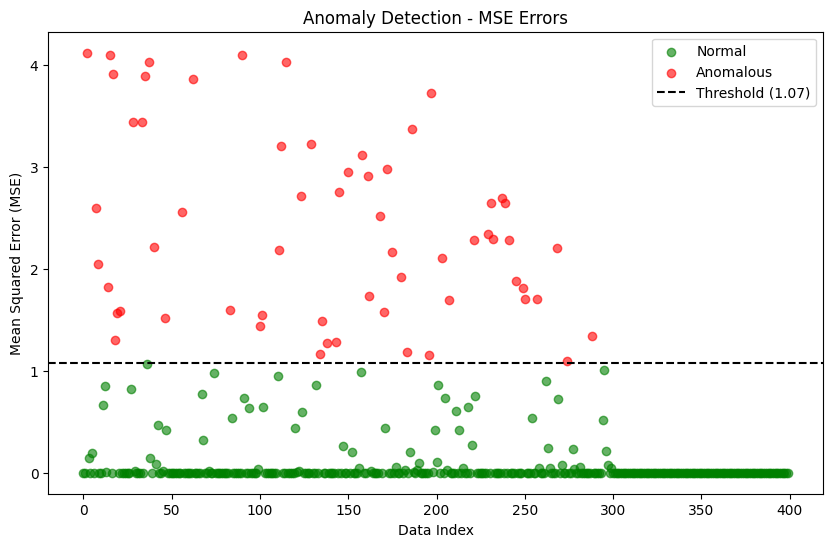

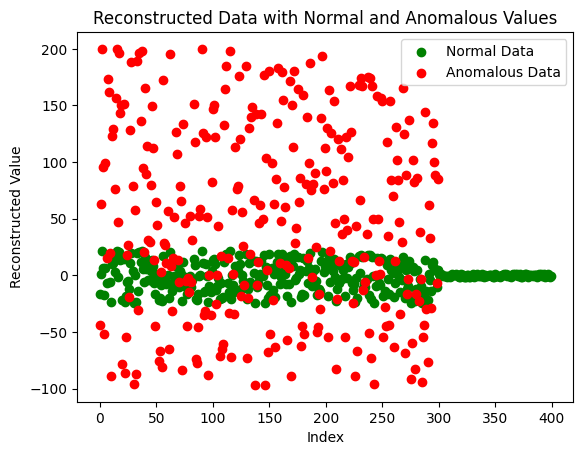

In [95]:
model = build()
normal = np.random.uniform(low=45, high=65, size=(100,))
anamoly = np.random.uniform(low=-100, high=200, size=(300,))
series = pd.Series(np.concatenate((anamoly, normal), axis=0), name='weight')
xTrain, xTest = normalize(data['weight'], series)
model = train(model, xTrain, 5)
reconstructed, mse, threshold = test(model, xTest)
plotErrors(reconstructed, mse, threshold)
plotReconstructedData(reconstructed, 45, 65)